# Detect Objects Using Deep Learning

## Data Preparation

In [3]:
import geoai
import leafmap

In [2]:
hudur_test_raster = "C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Study\\Training\\GeoAI\\codes\\HUDUR_HIGH_RESOLUTION_IMAGERY\\Xuddur_June_Sept_2023_R1C3.tif"

In [3]:
m = leafmap.Map(center=[43.889420,4.120808], zoom=16)
m.add_basemap("Esri.WorldImagery")
m.add_raster(hudur_test_raster, layer_name="HUDUR Test")
m

Map(center=[4.1404585, 43.912819999999996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

===== RASTER INFORMATION: C:\Users\edoar\OneDrive\Documenti\Work\Study\Training\GeoAI\codes\HUDUR_HIGH_RESOLUTION_IMAGERY\Xuddur_June_Sept_2023_R1C3.tif =====
Driver: GTiff
Dimensions: 16384 x 16384 pixels
Number of bands: 3
Data type: uint8
Coordinate Reference System: EPSG:4326
Georeferenced Bounds: BoundingBox(left=43.88729786273084, bottom=4.114936407624649, right=43.93834225482249, top=4.165980799716297)
Pixel Resolution: 3.1155024469999536e-06, 3.1155024470000078e-06
NoData Value: None

----- Band Statistics -----
Band 1:
  Min: 0.00
  Max: 255.00
  Mean: 154.99
  Std Dev: 42.86
Band 2:
  Min: 0.00
  Max: 255.00
  Mean: 113.64
  Std Dev: 39.51
Band 3:
  Min: 0.00
  Max: 255.00
  Mean: 92.57
  Std Dev: 36.65


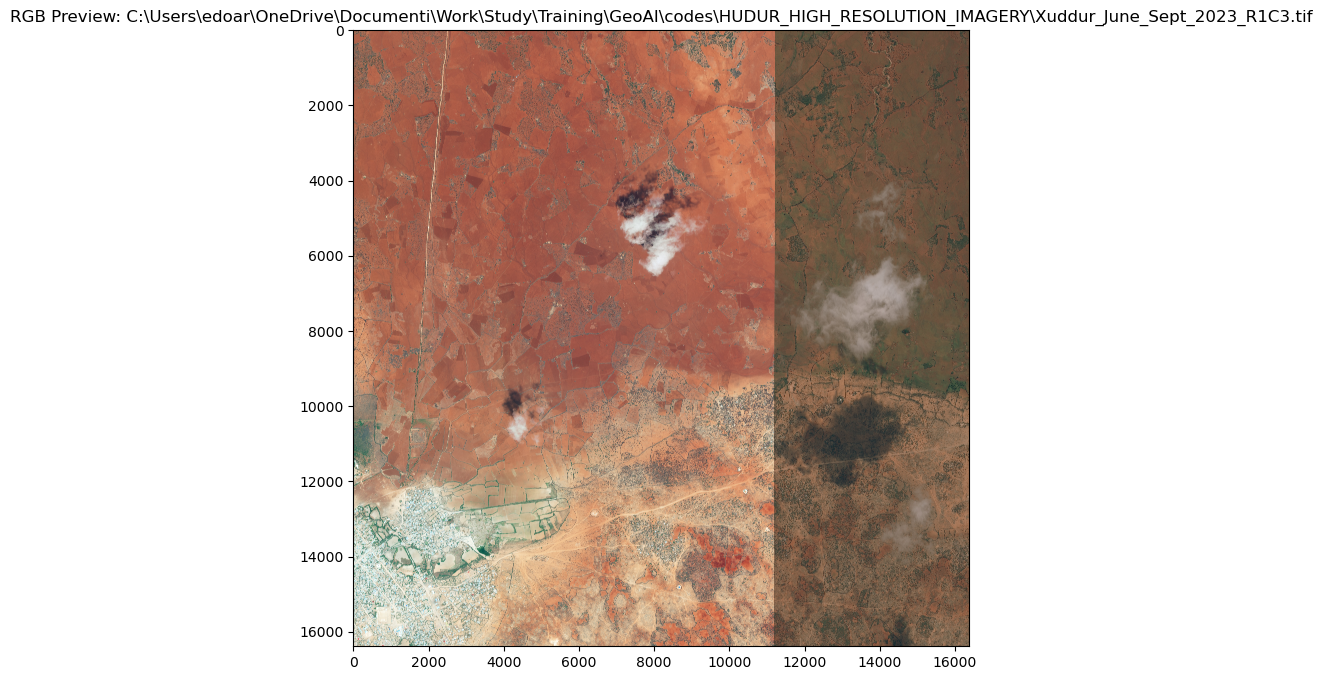

In [4]:
geoai.print_raster_info(hudur_test_raster )

In [8]:
bbox = m.user_roi_bounds()
bbox

[43.8911, 4.1223, 43.8965, 4.1278]

### Create Test Image 

In [11]:
clip_raster_path = r"C:\Users\edoar\OneDrive\Documenti\Work\Projects\GisWorkflows\GeoAi\DetectObjectsDeepLearning\input\hudur_clip_test.tif"
geoai.clip_raster_by_bbox(
    hudur_test_raster,
    clip_raster_path,
    bbox=(43.8904, 4.1151, 43.8987, 4.1215),
    bands=[1, 2, 3],
    bbox_type="geo",
)

'C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Projects\\GisWorkflows\\GeoAi\\DetectObjectsDeepLearning\\input\\hudur_clip_test.tif'

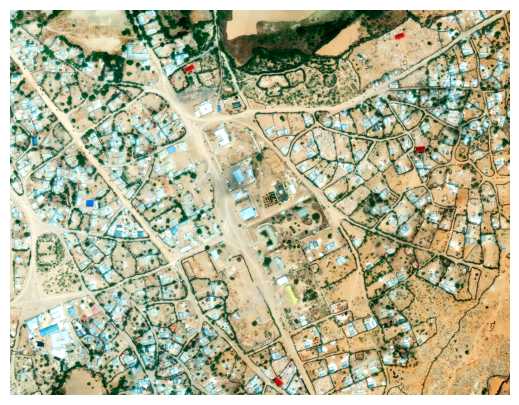

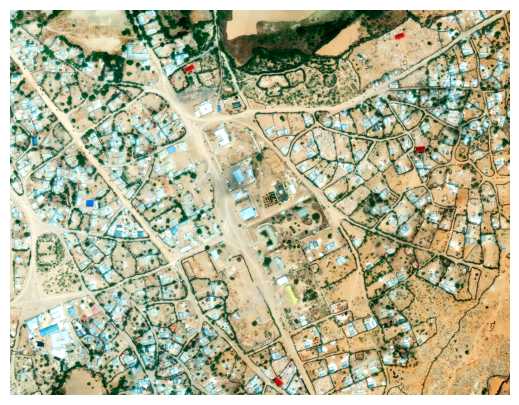

In [12]:
geoai.view_image(r"C:\Users\edoar\OneDrive\Documenti\Work\Projects\GisWorkflows\GeoAi\DetectObjectsDeepLearning\input\hudur_clip_test.tif")

### Download Buildings for Label

In [13]:
from geoai.download import (

    download_overture_buildings,
    extract_building_stats,
)

In [ ]:
# Download buildings
data_file = download_overture_buildings(
    bbox=bbox, 
    output="hudur_buildings.geojson",
    # Try the most recent known release, e.g., for December
    release="2025-11-19.0" 
)

In [6]:
train_raster_path = ("C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Study\\Training\\GeoAI\\codes\\hudur_clip.tif")
train_vector_path = ("C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Study\\Training\\GeoAI\\codes\\hudur_buildings.geojson")
test_raster_path = ("C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Study\\Training\\GeoAI\\codes\\hudur_clip_test2.tif")

In [27]:
geoai.view_vector_interactive(train_vector_path, tiles=train_raster_path)

In [9]:
out_folder = "output"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=512,
    stride=256,
    buffer_radius=0,
)


Raster info for C:\Users\edoar\OneDrive\Documenti\Work\Study\Training\GeoAI\codes\hudur_clip.tif:
  CRS: EPSG:4326
  Dimensions: 2343 x 2086
  Resolution: (3.1156636790412485e-06, 3.1160115052732266e-06)
  Bands: 3
  Bounds: BoundingBox(left=43.8905, bottom=4.1218, right=43.8978, top=4.1283)
Loaded 648 features from C:\Users\edoar\OneDrive\Documenti\Work\Study\Training\GeoAI\codes\hudur_buildings.geojson
Vector CRS: EPSG:4326
Found 1 unique classes: [None]


Generated: 72, With features: 66: 100%|██████████| 72/72 [00:06<00:00, 11.28it/s]


------- Export Summary -------
Total tiles exported: 72
Tiles with features: 66 (91.7%)
Average feature pixels per tile: 16388.4
Output saved to: output

------- Georeference Verification -------


In [10]:
geoai.view_raster("C:\\Users\\edoar\\OneDrive\\Documenti\\Work\\Study\\Training\\GeoAI\\codes\\output\\labels\\tile_000001.tif")

Map(center=[4.1275025, 43.892095499999996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [8]:
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=3,
    pretrained=False,
    batch_size=4,
    num_epochs=10,
    learning_rate=0.005,
    val_split=0.2,
)

NameError: name 'out_folder' is not defined

In [11]:
masks_path = "hudur_test_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"

In [12]:
geoai.object_detection(
    test_raster_path,
    masks_path,
    model_path,
    window_size=512,
    overlap=256,
    confidence_threshold=0.5,
    batch_size=4,
    num_channels=3,
)

Processing 80 windows with size 512x512 and overlap 256...


99it [00:13,  7.41it/s]                        

Inference completed in 13.38 seconds
Saved prediction to hudur_test_prediction.tif


In [13]:
gdf = geoai.raster_to_vector(masks_path, output_path="hudur_masks.geojson")

Vectorized data saved to hudur_masks.geojson


In [14]:
output_path = "hudur_test_predictionORT.geojson"
gdf = geoai.orthogonalize(masks_path, output_path, epsilon=2)

Processing 151 features...


Converting features: 100%|██████████| 151/151 [00:00<00:00, 27754.94shape/s]

Saving to hudur_test_predictionORT.geojson...
Done!


In [15]:
geoai.view_vector_interactive(output_path, tiles=test_raster_path)